## DEEP CONVOLUTIONAL GENERATIVE ADVERSERIAL NETWORK

#### The Discriminator and Generator

The purpose of the generator in a GAN is to learn to generate synthetic data that resembles real data samples. It does so by transforming the random noise vectors into meaningful output data, such as images. Through the adversarial training process, where it competes against the discriminator, the generator learns to produce outputs that are indistinguishable from real data to the discriminator.

The discriminator, on the other hand, is responsible for distinguishing between real and fake data samples. It receives both real and fake data samples as input during training and learns to differentiate between them.

By training the generator to fool the discriminator into classifying its generated samples as real, the generator indirectly learns the distribution of real data. However, it does so without explicitly seeing real data samples during training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    backend
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from IPython import display
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict, namedtuple
from itertools import product
import time
import json

# 0. Parameters

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

# 1. Data

In [3]:
train_data = utils.image_dataset_from_directory(
    "C:/Users/jorda/Documents/GenDL_datasets/lego_bricks_dl_dataset",
    labels = None,
    color_mode = "grayscale",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42,
    interpolation = "bilinear",
)

Found 46384 files belonging to 1 classes.


In [4]:
def preprocess(img):
    """Scales the data to be between [-1, 1] range."""
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

# 2. Model Architecture

In [11]:
### The discriminator
discriminator = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Conv2D(filters = 64, kernel_size = 4, strides = 2, padding = "same", use_bias = False, name="Conv2D_1"),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 128, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
    layers.BatchNormalization(momentum = 0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 256, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
    layers.BatchNormalization(momentum = 0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 512, kernel_size = 4, strides = 2, padding="same", use_bias = False),
    layers.BatchNormalization(momentum = 0.9),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 1, 
                  kernel_size = 4, 
                  strides = 1, 
                  padding = "valid", 
                  use_bias = False, 
                  activation = 'sigmoid'),
    layers.Flatten()
])

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

In [13]:
### The generator
generator = tf.keras.Sequential([
    layers.Input(shape=(100, 1)),
    layers.Reshape((1, 1, 100)),
    layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias = False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias = False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias = False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias = False),
    layers.BatchNormalization(momentum=0.9),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(
        1,
        kernel_size=4,
        strides=2,
        padding="same",
        use_bias = False,
        activation = 'tanh'
    )
])

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 4, 4, 512)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_19 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                      

# 3. Compiling the GAN

In [ ]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=100
)

dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
)

dcgan.fit(train, epochs=300)

In [65]:
# Define training function 
# Source: my_utils
def train_batch_ch3(net, batch, loss_function, optimizer):  
    """The training function for one batch."""
    with tf.GradientTape() as tape:
        y_hat = net(batch)
        l = loss_function(batch, y_hat)
        batch_loss = tf.reduce_mean(l)
    gradients = tape.gradient(batch_loss, net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, net.trainable_variables))
    # Return training loss
    return batch_loss

In [66]:
# Define the epoch class
# Source: github.com/ElisonSherton/Deep_Learning_Using_PyTorch
class Epoch:
    def __init__(self):
        # Keeps track of which epoch it is
        self.count = 0
        # Keeps track of the loss
        self.loss = 0
        # Keeps track of the number of correct predictions
        self.num_correct = 0
        # When to start
        self.start_time = 0

In [67]:
# Define the run manager class
# Source https://github.com/ElisonSherton/Deep_Learning_Using_PyTorch
# Modified to fit existing my_utils function outputs
class RunManager:
    def __init__(self):
        self.e = Epoch()
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        self.network = None
        self.loader = None
        self.tb = None
    
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment = f"-{run}")
#           self.tb.add_graph(network)
    
    def end_run(self):
        self.tb.close()
        self.e.count = 0
    
    def begin_epoch(self):
        self.e.start_time = time.time()
        self.e.count += 1
#       self.e.loss = 0
#       self.e.num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.e.start_time
        run_duration = time.time() - self.run_start_time
#       loss = self.e.loss / len(self.loader.dataset)
#       accuracy = self.e.num_correct / (len(self.loader.dataset))
        loss = train_loss
#       train_accuracy = train_acc
#       test_accuracy = test_acc
        
        self.tb.add_scalar('Loss', loss, self.e.count)
#       self.tb.add_scalar('Train_Accuracy', train_accuracy, self.e.count)
#       self.tb.add_scalar('Test_Accuracy', test_accuracy, self.e.count)

        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.e.count)
            self.tb.add_histogram(f"{name}.grad", param.grad, self.e.count)
            
        results = {'Run': self.run_count, 
                   'Epoch': self.e.count, 
                   'Loss': loss,
#                   'Train_Accuracy': train_accuracy,
#                   'Test_Accuracy': test_accuracy,
                   'Epoch Duration': epoch_duration,
                   'Run Duration': run_duration}
        
        for k, v in self.run_params._asdict().items(): 
            results[k] = v
        
        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        display.clear_output(wait = True)
        print(df)
        
    def track_loss(self, loss):
        self.e.loss += loss.item() * self.loader.batch_size
    
#   def track_num_correct(self, pred, labels):
#       self.e.num_correct += pred.argmax(dim = 1).eq(labels).sum().item()
        
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [68]:
# Define the parameter builder class
# Source: github.com/ElisonSherton/Deep_Learning_Using_PyTorch 
class RunBuilder:
    @staticmethod
    def get_runs(params):
        # Creates a named tuple which we can use to access values in organized way of .notation
        Run = namedtuple('Run', params.keys())
        # Create a container to hold all the combination of params
        runs = []
        
        # Compute the Cartesian product of parameters
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

## 3. Train the Model

In [69]:
# Create the parameter dictionary 
params = OrderedDict(
    lr = [.0005],
    dropout_p = [.25],
    batch_size = [32],
    num_epochs = [5],
)

In [ ]:
m = RunManager()
for run in RunBuilder.get_runs(params):
    # Task 1 - Read dataset and create dataloader
    data_gen = ImageDataGenerator(rescale=1./255)

    data_flow = data_gen.flow_from_directory(DATA_FOLDER,
                                             target_size = INPUT_SHAPE[:2],
                                             batch_size = run.batch_size,
                                             shuffle = True,
                                             class_mode = 'input',
                                             interpolation = 'bilinear')
    
    # Task 2 - Create the model
    VAE = Autoencoder(INPUT_SHAPE, LATENT_DIM, run.dropout_p)

    # Task 3 - Create the loss and optimizer
    optimizer = Adam(learning_rate = run.lr)
    loss_function = vae_loss
    
    # Task 4 - Compile the Model
    VAE.compile(optimizer = optimizer, loss = vae_loss)

    # Task 5 - Write the training script and train the model
    m.begin_run(run, VAE, data_flow)
    
    # Set the model to training mode
    VAE.trainable = True
    
    for epoch in range(run.num_epochs):
        m.begin_epoch()
        epoch_loss = []
        for training_batch in data_flow:
            train_metrics = train_batch_ch3(VAE, training_batch[0], loss_function, optimizer)
            batch_loss = train_metrics
            epoch_loss += batch_loss
        train_loss = np.mean(epoch_loss)
        m.end_epoch()
    m.end_run()
    
    # Task 6 - Display reconstructions 
    grid_width, grid_height = (10, 3)
    z_sample = np.random.normal(size=(grid_width * grid_height, 200))
    print(z_sample.shape)
    reconstructions = VAE.decoder.predict(z_sample)

    fig = plt.figure(figsize=(18, 5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(grid_width * grid_height):
        ax = fig.add_subplot(grid_height, grid_width, i + 1)
        ax.axis("off")
        ax.imshow(reconstructions[i, :, :])
        
# Task 7 - Save the run results        
m.save('results_1')

## 5. Display the results

In [ ]:
# Display the results
pd.DataFrame.from_dict(m.run_data, orient='columns').head()

(30, 200)
1/1 [==============================] - 0s 496ms/step


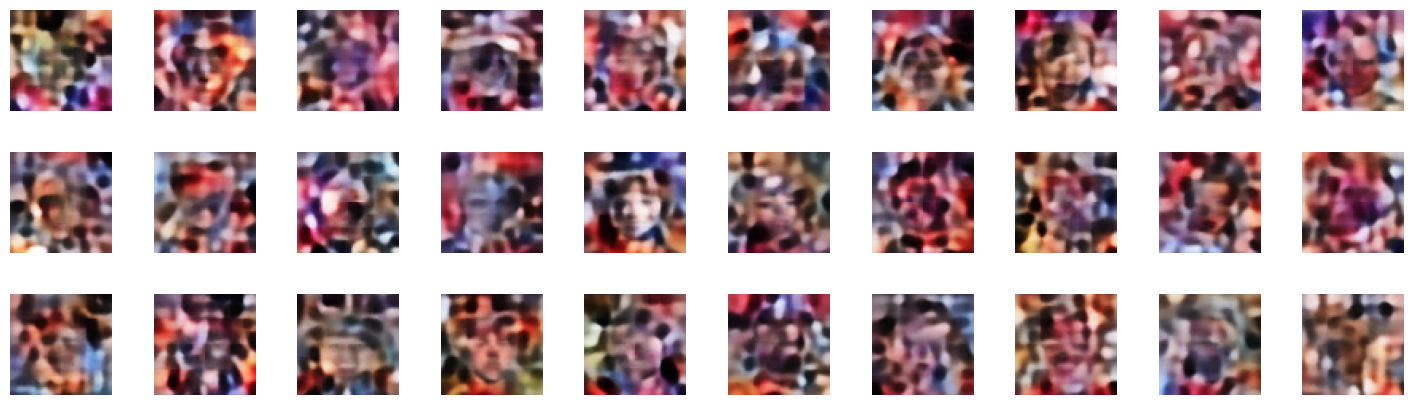

In [74]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 200))
print(z_sample.shape)
reconstructions = VAE.decoder.predict(z_sample)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])